In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split

from datetime import datetime, timedelta

In [4]:
import pickle
import os

In [5]:
# Load data
base_path = './../Azure-Mantainance/archive/'
telemetry = pd.read_csv(os.path.join(base_path, 'PdM_telemetry.csv'))
errors = pd.read_csv(os.path.join(base_path, 'PdM_errors.csv'))
maint = pd.read_csv(os.path.join(base_path, 'PdM_maint.csv'))
failures = pd.read_csv(os.path.join(base_path, 'PdM_failures.csv'))
machines = pd.read_csv(os.path.join(base_path, 'PdM_machines.csv'))

In [6]:
display(telemetry)

datetime  machineID        volt      rotate    pressure  \
0       2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1       2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2       2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3       2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4       2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   
...                     ...        ...         ...         ...         ...   
876095  2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
876096  2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
876097  2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
876098  2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
876099  2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration  
0       45.087686  
1       43.413973  
2       34.178847  
3       41.122144  
4       25.990511  
...           ...  
876095  50.771941  
876096  35.123072  
876097  48.314561  
876098  44.835259  
876099  37.845245  

[876100 rows x 6 columns]

In [7]:
display(errors)

datetime  machineID errorID
0     2015-01-03 07:00:00          1  error1
1     2015-01-03 20:00:00          1  error3
2     2015-01-04 06:00:00          1  error5
3     2015-01-10 15:00:00          1  error4
4     2015-01-22 10:00:00          1  error4
...                   ...        ...     ...
3914  2015-11-21 08:00:00        100  error2
3915  2015-12-04 02:00:00        100  error1
3916  2015-12-08 06:00:00        100  error2
3917  2015-12-08 06:00:00        100  error3
3918  2015-12-22 03:00:00        100  error3

[3919 rows x 3 columns]

In [8]:
display(maint)

datetime  machineID   comp
0     2014-06-01 06:00:00          1  comp2
1     2014-07-16 06:00:00          1  comp4
2     2014-07-31 06:00:00          1  comp3
3     2014-12-13 06:00:00          1  comp1
4     2015-01-05 06:00:00          1  comp4
...                   ...        ...    ...
3281  2015-10-10 06:00:00        100  comp3
3282  2015-10-25 06:00:00        100  comp4
3283  2015-11-09 06:00:00        100  comp4
3284  2015-12-09 06:00:00        100  comp2
3285  2015-12-24 06:00:00        100  comp2

[3286 rows x 3 columns]

In [9]:
display(failures)

datetime  machineID failure
0    2015-01-05 06:00:00          1   comp4
1    2015-03-06 06:00:00          1   comp1
2    2015-04-20 06:00:00          1   comp2
3    2015-06-19 06:00:00          1   comp4
4    2015-09-02 06:00:00          1   comp4
..                   ...        ...     ...
756  2015-11-29 06:00:00         99   comp3
757  2015-12-14 06:00:00         99   comp4
758  2015-02-12 06:00:00        100   comp1
759  2015-09-10 06:00:00        100   comp1
760  2015-12-09 06:00:00        100   comp2

[761 rows x 3 columns]

In [10]:
display(machines)

machineID   model  age
0           1  model3   18
1           2  model4    7
2           3  model3    8
3           4  model3    7
4           5  model3    2
..        ...     ...  ...
95         96  model2   10
96         97  model2   14
97         98  model2   20
98         99  model1   14
99        100  model4    5

[100 rows x 3 columns]

# EDA Telemetry Data

In [11]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))

telemetry.describe()

Total number of telemetry records: 876100


machineID           volt         rotate       pressure  \
count  876100.000000  876100.000000  876100.000000  876100.000000   
mean       50.500000     170.777736     446.605119     100.858668   
std        28.866087      15.509114      52.673886      11.048679   
min         1.000000      97.333604     138.432075      51.237106   
25%        25.750000     160.304927     412.305714      93.498181   
50%        50.500000     170.607338     447.558150     100.425559   
75%        75.250000     181.004493     482.176600     107.555231   
max       100.000000     255.124717     695.020984     185.951998   

           vibration  
count  876100.000000  
mean       40.385007  
std         5.370361  
min        14.877054  
25%        36.777299  
50%        40.237247  
75%        43.784938  
max        76.791072

# EDA Errors Data

In [12]:
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('object')

print("Total number of error records: %d" % len(errors.index))

Total number of error records: 3919


In [13]:
errors_f = errors.merge(machines, on=['machineID'], how='left')
errors_f.sort_values(['machineID', 'datetime'], ascending=[True, True], inplace=True)
errors_f['days_bw_errors'] = errors_f.groupby(['machineID', 'errorID'])['datetime'].diff().dt.total_seconds()/(24*3600)
errors_f['age_bucket'] = pd.cut(errors_f['age'], bins=[0,5,10,15,20])

<AxesSubplot: xlabel='model'>

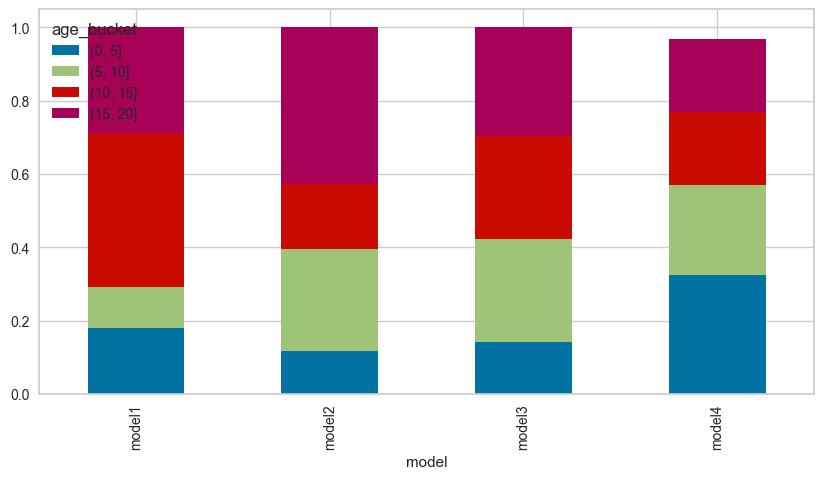

In [14]:
# normalize errors by age and model
(errors_f.groupby(['model', 'age_bucket'])['machineID'].count() / errors_f.groupby(['model'])['machineID'].count()).unstack().plot(kind='bar', stacked=True, figsize=(10, 5))

#change it to plotly

In [15]:
px.histogram(errors_f, x='age', color='model', facet_col='model', title='Error Age Distribution', width=1200, height=400)


In [16]:
px.box(errors_f, x='model', y='age', color='model', title='Error Distribution by Model', width=1200, height=400)

In [17]:
px.box(errors_f, x='errorID', y='age', color='errorID', title='Error Distribution by Model', width=1200, height=400)

In [18]:
px.bar(errors_f.groupby(['model', 'errorID'])['machineID'].count().reset_index(name='count'), 
       x='model', y='count', color='errorID', barmode='group', 
       title='Error Distribution by Model', width=1200, height=400)

In [19]:
px.histogram(errors_f, x='days_bw_errors', color='errorID', facet_col='errorID', title='Days between Errors', width=1200, height=400, nbins=40)

# EDA Maintainance Data

In [20]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('object')

print("Total number of maintenance records: %d" % len(maint.index))
maint.head()

Total number of maintenance records: 3286


datetime  machineID   comp
0 2014-06-01 06:00:00          1  comp2
1 2014-07-16 06:00:00          1  comp4
2 2014-07-31 06:00:00          1  comp3
3 2014-12-13 06:00:00          1  comp1
4 2015-01-05 06:00:00          1  comp4

In [21]:
maint_f = maint.merge(machines, on=['machineID'], how='left')

In [22]:
maint_f

datetime  machineID   comp   model  age
0    2014-06-01 06:00:00          1  comp2  model3   18
1    2014-07-16 06:00:00          1  comp4  model3   18
2    2014-07-31 06:00:00          1  comp3  model3   18
3    2014-12-13 06:00:00          1  comp1  model3   18
4    2015-01-05 06:00:00          1  comp4  model3   18
...                  ...        ...    ...     ...  ...
3281 2015-10-10 06:00:00        100  comp3  model4    5
3282 2015-10-25 06:00:00        100  comp4  model4    5
3283 2015-11-09 06:00:00        100  comp4  model4    5
3284 2015-12-09 06:00:00        100  comp2  model4    5
3285 2015-12-24 06:00:00        100  comp2  model4    5

[3286 rows x 5 columns]

In [23]:
px.bar(maint_f.groupby(['model', 'comp'])['machineID'].count().reset_index(name='count'), 
       x='model', y='count', color='comp', barmode='group', 
       title='Maintainance Distribution by Model', width=1200, height=400)

In [24]:
px.box(maint_f, x='model', y='age', color='model', title='Maintainance Distribution by Model', width=1200, height=400)

In [25]:
px.box(maint_f, x='comp', y='age', color='comp', title='Maintainance Distribution by Model', width=1200, height=400)

# EDA Machine Data

In [26]:
machines['model'] = machines['model'].astype('object')

print("Total number of machines: %d" % len(machines.index))
machines.head()


Total number of machines: 100


machineID   model  age
0          1  model3   18
1          2  model4    7
2          3  model3    8
3          4  model3    7
4          5  model3    2

In [27]:
px.histogram(machines, x='age', color='model', facet_col='model', title='Machine Age Distribution', width=1200, height=400)


# EDA Failure Data

In [28]:
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('object')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


datetime  machineID failure
0 2015-01-05 06:00:00          1   comp4
1 2015-03-06 06:00:00          1   comp1
2 2015-04-20 06:00:00          1   comp2
3 2015-06-19 06:00:00          1   comp4
4 2015-09-02 06:00:00          1   comp4

In [29]:
failures_f = failures.merge(machines, on=['machineID'], how='left')
failures_f.sort_values(['machineID', 'datetime'], ascending=[True, True], inplace=True)
failures_f['days_bw_failures'] = failures_f.groupby(['machineID', 'failure'])['datetime'].diff().dt.total_seconds()/(24*3600)
failures_f['age_bucket'] = pd.cut(failures_f['age'], bins=[0,5,10,15,20])

In [30]:
failures_f

datetime  machineID failure   model  age  days_bw_failures  \
0   2015-01-05 06:00:00          1   comp4  model3   18               NaN   
1   2015-03-06 06:00:00          1   comp1  model3   18               NaN   
2   2015-04-20 06:00:00          1   comp2  model3   18               NaN   
3   2015-06-19 06:00:00          1   comp4  model3   18             165.0   
4   2015-09-02 06:00:00          1   comp4  model3   18              75.0   
..                  ...        ...     ...     ...  ...               ...   
756 2015-11-29 06:00:00         99   comp3  model1   14              90.0   
757 2015-12-14 06:00:00         99   comp4  model1   14              45.0   
758 2015-02-12 06:00:00        100   comp1  model4    5               NaN   
759 2015-09-10 06:00:00        100   comp1  model4    5             210.0   
760 2015-12-09 06:00:00        100   comp2  model4    5               NaN   

    age_bucket  
0     (15, 20]  
1     (15, 20]  
2     (15, 20]  
3     (15, 20]  
4     (15, 20]  
..         ...  
756   (10, 15]  
757   (10, 15]  
758     (0, 5]  
759     (0, 5]  
760     (0, 5]  

[761 rows x 7 columns]

In [31]:
px.histogram(failures_f, x='days_bw_failures', color='failure', facet_col='failure', title='Days between Failures', width=1200, height=400, nbins=20)

In [32]:
px.box(failures_f, x='failure', y='days_bw_failures', color='failure', title='Days between Failures', width=1200, height=400)

In [33]:
px.box(failures_f, x='model', y='age', color='model', title='Failure Distribution by Model', width=1200, height=400)

In [34]:
px.box(failures_f, x='failure', y='age', color='failure', title='Failure Distribution by Model', width=1200, height=400)

In [35]:
px.box(failures_f, x='model', y='age', color='failure', title='Failure Distribution by Model', width=1200, height=400)

In [36]:
px.histogram(machines, x='age', color='model', facet_col='model', title='Machine Age Distribution', width=1200, height=400)

In [37]:
# One-hot & Label encode model features:

def getOneHotEncodedFeatures(df, onehot_encode_cols=[]):

    
    one_hot_encoder = OneHotEncoder()
    onehot_encoded_data = one_hot_encoder.fit_transform(df[onehot_encode_cols]).toarray()
    one_hot_encoded_data = pd.DataFrame(onehot_encoded_data, columns=one_hot_encoder.get_feature_names_out(onehot_encode_cols))

    df = pd.concat([df.drop(onehot_encode_cols, axis=1), one_hot_encoded_data], axis=1)

    return df

def getLabelEncodedFeatures(df, label_encode_cols=[]):

    if len(label_encode_cols) > 0:
        label_encoder = LabelEncoder()
        label_encoded_data = df[label_encode_cols].apply(label_encoder.fit_transform)

    df = pd.concat([df.drop(label_encode_cols, axis=1), label_encoded_data], axis=1)

    return df

In [38]:
#merge telemetry data with failures
dt = telemetry.merge(failures, on=['datetime', 'machineID'], how='left')

#merge telemetry data with errors
dt = dt.merge(errors, on=['datetime', 'machineID'], how='left')

#merge telemetry data with maintenance
dt = dt.merge(maint, on=['datetime', 'machineID'], how='left')

#merge telemetry data with machine data
dt = dt.merge(machines, on=['machineID'], how='left')

#fill missing comp values where failure occured:
dt.loc[(dt.comp.isnull()) & (~dt.failure.isnull()),'comp'] = dt.loc[(dt.comp.isnull()) & (~dt.failure.isnull()),'failure']

dt['error_fl'] = (~dt['errorID'].isnull()).astype('int')
dt['failure_fl'] = (~dt['failure'].isnull()).astype('int')
dt['mantainance_fl'] = (~dt['comp'].isnull()).astype('int')
dt['fail_maint_fl'] = np.where(dt['comp'].isnull(), 'No-Mantainance', np.where(dt['failure'].isnull(), 'Regular-Mantainance', 'Failure-Mantainance'))
#dt.loc[dt['errorID'].isnull(), 'errorID'] = 'No-Error'

#back fill failures for the last 24 hours

In [39]:
dt_f = getOneHotEncodedFeatures(dt, ['errorID','failure'])

In [40]:
display(dt.head())

datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration failure errorID comp   model  age  error_fl  failure_fl  \
0  45.087686     NaN     NaN  NaN  model3   18         0           0   
1  43.413973     NaN     NaN  NaN  model3   18         0           0   
2  34.178847     NaN     NaN  NaN  model3   18         0           0   
3  41.122144     NaN     NaN  NaN  model3   18         0           0   
4  25.990511     NaN     NaN  NaN  model3   18         0           0   

   mantainance_fl   fail_maint_fl  
0               0  No-Mantainance  
1               0  No-Mantainance  
2               0  No-Mantainance  
3               0  No-Mantainance  
4               0  No-Mantainance

### Analysis of Telemetry data with errors, maintainance and failure logs

In [41]:
# Create subplots with four line charts
fig = make_subplots(rows=6, cols=1, subplot_titles=('Volt', 'Rotate', 'Pressure', 'Vibration','Error', 'Mantainance-Failure'), shared_xaxes=True)

plot_df = dt[dt['machineID'] == 1]

# Add line charts to subplots
fig.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df['volt'], mode='lines', name='Volt'), row=1, col=1)
fig.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df['rotate'], mode='lines', name='Rotate'), row=2, col=1)
fig.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df['pressure'], mode='lines', name='Pressure'), row=3, col=1)
fig.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df['vibration'], mode='lines', name='Vibration'), row=4, col=1)
fig.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df['error_fl'], mode='lines', name='Error Flag'), row=5, col=1)
fig.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df['mantainance_fl'], mode='lines', name='Mantainance Flag'), row=6, col=1)
fig.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df['failure_fl'], mode='lines', name='Failure Flag'), row=6, col=1)

# Update layout
fig.update_layout(title_text='Telemetry Data Over Time', showlegend=True, height=800, width=1200)

# Show the figure
fig.show()


In [42]:
# Create subplots with four line charts
fig = make_subplots(rows=9, cols=1, shared_xaxes=True)

plot_df = dt_f[dt_f['machineID'] == 1]

# Add line charts to subplots
for error in range(1, 6):
    fig.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df[f'errorID_error{error}'], mode='lines', name=f'Error {error}'), row=error, col=1)

for comp in range(6, 10):
    fig.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df[f'failure_comp{comp - 5}'], mode='lines', name=f'Failure {comp -5}'), row=comp, col=1)

# Update layout
fig.update_layout(title_text='Error-Failure Logs Over Time', showlegend=True, height=600, width=1000)

# Show the figure
fig.show()


### Check the relationship between error type and failure type

In [43]:
err_fail_dt = failures.merge(errors, on=['machineID'], how='left')
err_fail_dt = err_fail_dt[err_fail_dt.datetime_y < err_fail_dt.datetime_x]
err_fail_dt.sort_values(by=['machineID', 'datetime_x','datetime_y'], inplace=True, ascending=False)
err_fail_dt = err_fail_dt.groupby(['machineID', 'datetime_x']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
err_fail_dt.rename(columns={'datetime_x': 'dt_failure', 'datetime_y': 'dt_error'}, inplace=True)

In [44]:
(err_fail_dt['dt_failure'] - err_fail_dt['dt_error']).dt.days.value_counts()

# the failure log are within one day of errors, suggesting that the manatinance in case of failure happened on same or next day

1    646
0     59
dtype: int64

In [45]:
corr_features = ['errorID_error1', 'errorID_error2', 'errorID_error3', 'errorID_error4', 'errorID_error5', 'failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4']
cm = getOneHotEncodedFeatures(err_fail_dt, ['failure', 'errorID'])[corr_features].corr()

# Creating a correlation heatmap with Plotly Express
fig = px.imshow(cm, labels=dict(color='Correlation'), x=cm.columns, y=cm.index)

# Customizing the layout
fig.update_layout(title='Correlation Heatmap', xaxis_title='Features', yaxis_title='Features')

# Showing the plot
fig.show()

# correlation plot shows correlation between error type and failure type, suggesting that certain errors are precursors to certain failures

# Feature Engineering

### 1. Identify temporal features from telemetry data

In [46]:


def getLagAggFeatures(df, datetime_col='datetime', groupby_col=['machineID'], 
                      resample='3H', aggfunc='sum', rollfunc='mean', roll_window=None, 
                      feature_list=['volt', 'rotate', 'pressure', 'vibration']):
    '''
    This function generates lag and aggregate features from the input dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    datetime_col : str
        Name of the datetime column in the input dataframe
    groupby_col : list
        List of columns to group by
    resample : str
        Resampling frequency
    aggfunc : str
        Aggregation function to use
    rollfunc : str
        Rolling function to use
    roll_window : int
        Size of the rolling window
    feature_list : list
        List of features to generate lag and aggregate features for
    
    Returns:
    --------
    pandas.DataFrame
        Dataframe with lag and aggregate features
    '''
    
    tmp = df.set_index(datetime_col).groupby(groupby_col)[feature_list].resample(resample, label='right').agg(aggfunc).reset_index()

    if roll_window is not None:
        tmp.set_index(datetime_col, inplace=True)
        tmp = tmp.groupby(groupby_col).rolling(window=roll_window, center=False).agg(rollfunc).reset_index()
        tmp.rename(columns={col: f'{col}_{rollfunc}_roll_{roll_window}' for col in feature_list}, inplace=True)
    else:
        tmp = tmp.reset_index()
        tmp.rename(columns={col: f'{col}_{aggfunc}' for col in feature_list}, inplace=True)

    tmp.set_index([datetime_col] + groupby_col, inplace=True)

    return tmp

In [47]:
def getTelemetryTemporalFeatures(df, datetime_col='datetime', groupby_col=['machineID'], 
                                 resample='3H', roll_window_list=[7, 14, 21], 
                                 feature_list=['volt', 'rotate', 'pressure', 'vibration']):
    '''
    This function generates temporal features from the telemetry data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    datetime_col : str
        Name of the datetime column in the input dataframe
    groupby_col : list
        List of columns to group by
    resample : str
        Resampling frequency
    roll_window_list : list
        List of rolling window sizes
    feature_list : list
        List of features to generate temporal features for
    
    Returns:
    --------
    pandas.DataFrame
        Dataframe with temporal features
    '''
    
    # Get mean and standard deviation of telemetry data
    telemetry_mean = getLagAggFeatures(df, datetime_col=datetime_col, groupby_col=groupby_col, 
                                       resample=resample, aggfunc='mean', rollfunc='mean', roll_window=None, 
                                       feature_list=feature_list)
    telemetry_sd = getLagAggFeatures(df, datetime_col=datetime_col, groupby_col=groupby_col, 
                                     resample=resample, aggfunc='std', rollfunc='mean', roll_window=None, 
                                     feature_list=feature_list)
    
    # Get lagged mean and standard deviation of telemetry data
    lag_dt_list =[]
    for roll_window in roll_window_list:
        telemetry_mean_roll = getLagAggFeatures(df, datetime_col=datetime_col, groupby_col=groupby_col, 
                                                resample=resample, aggfunc='first', rollfunc='mean', roll_window=roll_window, 
                                                feature_list=feature_list)
        lag_dt_list.append(telemetry_mean_roll)

        telemetry_sd_roll = getLagAggFeatures(df, datetime_col=datetime_col, groupby_col=groupby_col, 
                                              resample=resample, aggfunc='first', rollfunc='std', roll_window=roll_window, 
                                              feature_list=feature_list)
        lag_dt_list.append(telemetry_sd_roll)
        
    # Concatenate all features and drop null values
    telemetry_f = pd.concat([telemetry_mean, telemetry_sd] + lag_dt_list, axis=1).dropna().reset_index()
    telemetry_f.drop(['index'], axis=1, inplace=True)

    return telemetry_f

### 2. Identifying Lag Features from Error Data on a window of 24 hours

In [48]:
def getErrorLagFeatures(df, datetime_col = 'datetime', resample='3H',roll_window = None,):

    error_agg = pd.get_dummies(df.set_index(datetime_col)[['machineID','errorID']]).reset_index()

    error_agg.columns = ['datetime', 'machineID',
                        'error1', 'error2', 'error3', 'error4', 'error5']

    error_roll = getLagAggFeatures(error_agg, groupby_col=['machineID'], 
                                   resample=resample, aggfunc='first',rollfunc='sum',roll_window=roll_window, 
                                   feature_list=['error1', 'error2', 'error3', 'error4', 'error5']).dropna().reset_index()
    
    return error_roll


### 3. Identify Maintainance features

In [49]:
# only keep regular maintainance records (not failure maintainance)

def getMaintainanceFeatures(df, telemetry):

    maint_agg = pd.get_dummies(df.set_index('datetime')).reset_index()

    maint_agg.columns = ['datetime', 'machineID',
                        'comp1', 'comp2', 'comp3', 'comp4']

    maint_agg = telemetry[['datetime', 'machineID']].merge(maint_agg, on=['datetime','machineID'],
                                                        how='outer').fillna(False).sort_values(by=['machineID', 'datetime'])


    components = ['comp1', 'comp2', 'comp3', 'comp4']
    for comp in components:
        maint_agg.loc[maint_agg[comp]<1, comp] = None
        maint_agg.loc[-maint_agg[comp].isnull(),comp] = maint_agg.loc[-maint_agg[comp].isnull(), 'datetime']
        maint_agg[comp] = maint_agg[comp].fillna(method='ffill')

    maint_agg = maint_agg.loc[maint_agg['datetime'] > pd.to_datetime('2015-01-01')]

    for comp in components:
        maint_agg[comp] = (maint_agg["datetime"] - pd.to_datetime(maint_agg[comp])) / np.timedelta64(1, "D")

    return maint_agg

### 4. One-hot encode and label encode features

In [50]:
# calculate all features

telemetry_f = getTelemetryTemporalFeatures(dt, datetime_col='datetime', groupby_col = ['machineID'], 
                                           resample='3H', roll_window_list= [7, 14, 21], 
                                           feature_list=['volt','rotate','pressure','vibration'])
  
telemetry_f = telemetry_f.loc[telemetry_f['datetime'] > pd.to_datetime('2015-01-01')]

error_roll = getErrorLagFeatures(dt, datetime_col='datetime', resample='3H',roll_window = 24)

maint_f = maint.merge(failures, on=['machineID','datetime'], how='left')
maint_f = maint_f[maint_f['failure'].isnull()]
maint_f.drop(['failure'], axis=1, inplace=True)

maint_roll = getMaintainanceFeatures(maint_f, telemetry_f)

final_feat = telemetry_f.merge(error_roll, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(maint_roll, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')
final_feat = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')

#maintainance usually happens 24 hours after failure, so fill failure records for last 24 hours 
final_feat['failure'] = final_feat['failure'].bfill(limit=7).fillna('none')

ff = getOneHotEncodedFeatures(final_feat, onehot_encode_cols=['model'])
ff_o = ff.copy()
ff = getLabelEncodedFeatures(ff, label_encode_cols=['failure'])

In [51]:
display(ff_o.head())

datetime  machineID   volt_mean  rotate_mean  pressure_mean  \
0 2015-01-03 21:00:00          1  162.387954   454.140377      92.651129   
1 2015-01-04 00:00:00          1  174.243192   394.998095      99.829845   
2 2015-01-04 03:00:00          1  176.443361   459.528820     111.855296   
3 2015-01-04 06:00:00          1  186.092896   451.641253     107.989359   
4 2015-01-04 09:00:00          1  166.281848   453.787824     106.187582   

   vibration_mean   volt_std  rotate_std  pressure_std  vibration_std  ...  \
0       54.261635   4.563331   57.747656      4.754203       5.118076  ...   
1       46.930738   6.268730   29.167663     10.564287       6.822855  ...   
2       55.296056  16.330285   20.602657      7.064583       4.651468  ...   
3       55.308074  13.489090   62.185045      5.118176       4.904365  ...   
4       51.990080  24.276228   23.621315     11.176731       3.394073  ...   

    comp1    comp2    comp3    comp4  age  failure  model_model1  \
0  21.625  216.625  156.625  171.625   18     none           0.0   
1  21.750  216.750  156.750  171.750   18     none           0.0   
2  21.875  216.875  156.875  171.875   18     none           0.0   
3  22.000  217.000  157.000  172.000   18     none           0.0   
4  22.125  217.125  157.125  172.125   18    comp4           0.0   

   model_model2  model_model3  model_model4  
0           0.0           1.0           0.0  
1           0.0           1.0           0.0  
2           0.0           1.0           0.0  
3           0.0           1.0           0.0  
4           0.0           1.0           0.0  

[5 rows x 49 columns]

# Modelling

In [52]:
from sklearn.metrics import classification_report

In [53]:
X = ff.drop(['datetime','machineID','failure'], axis=1)
Y = ff['failure']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, stratify=None)

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(Y.unique()),  # Number of classes in the target variable
    eval_metric='mlogloss',  # Multiclass logloss
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=42
)

tscv = TimeSeriesSplit(n_splits=5)

cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=tscv, scoring='f1_weighted')

print("CV score list", cv_scores)

#train on all data
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print("score on test", xgb_model.score(X_test, y_test))

classification_rep = classification_report(y_test, y_pred)

print("\nClassification Report\n")
print(classification_report(y_test, y_pred))


CV score list [0.99491021 0.99665294 0.99682798 0.99739382 0.99735987]
score on test 0.995816763931209

Classification Report

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       312
           1       0.88      0.90      0.89       434
           2       0.93      0.98      0.96       329
           3       0.86      0.94      0.89       231
           4       1.00      1.00      1.00     56783

    accuracy                           1.00     58089
   macro avg       0.91      0.94      0.92     58089
weighted avg       1.00      1.00      1.00     58089



# Train with autoML workflow (using PyCaret)

In [54]:
from pycaret.classification import *

In [55]:
ff_o.sort_values(['machineID', 'datetime'], ascending=[True, True], inplace=True)

In [56]:
#setup the experiment
exp = ClassificationExperiment()
exp_name = exp.setup(ff_o, target = 'failure', session_id = 123, experiment_name='mclass-predict-maintainance', fold_strategy='timeseries', fold=5, data_split_shuffle=False, data_split_stratify=False)

In [57]:
model_list = ['rf','lightgbm','xgboost','catboost']
best_model = exp.compare_models(include=model_list)

In [64]:
#parameter hypertuning for xgboost:

tuned_xgboost = exp.tune_model(best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [65]:
tuned_xgboost

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Model Evaluation on Test Data

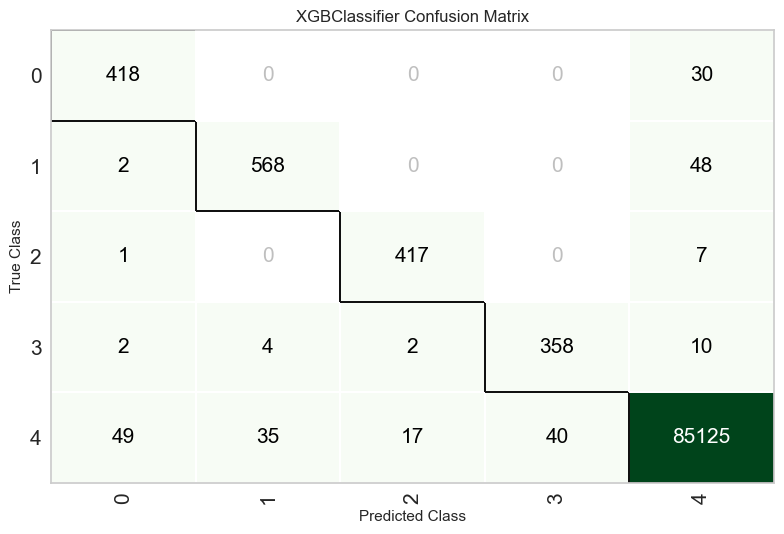

In [66]:
exp.plot_model(tuned_xgboost, plot='confusion_matrix')

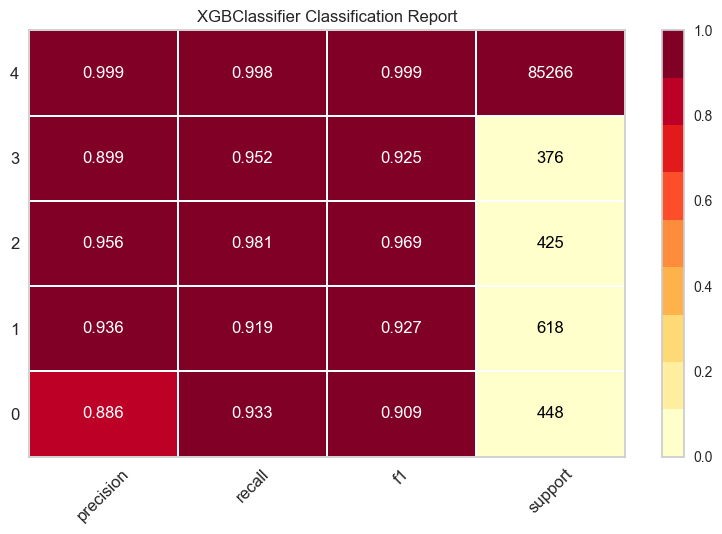

In [67]:
exp.plot_model(tuned_xgboost, plot='class_report')

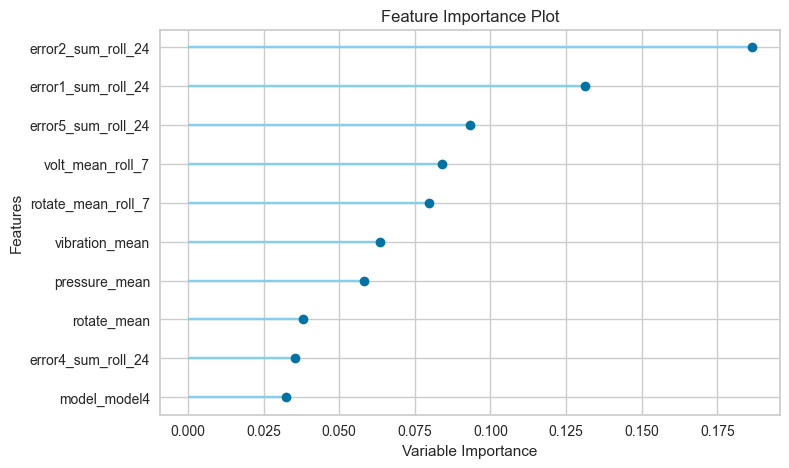

In [68]:
exp.plot_model(tuned_xgboost, plot='feature')